In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from redist import modifier
from redist import plot

import sys, os
path2add = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))
if (not (path2add in sys.path)) :
    sys.path.append(path2add)
    
from knunu import knunu_utils
from ksnunu import ksnunu_utils

from bayesian_pyhf import plotting
import arviz as az
import corner

In [2]:
files       = ['../knunu/knunu_model.json', '../ksnunu/ksnunu_model.json']
alt_dists   = [knunu_utils.alt_pred().distribution, ksnunu_utils.alt_pred().distribution]
null_dists  = [knunu_utils.null_pred().distribution, ksnunu_utils.null_pred().distribution]

model, data = modifier.combine(files, alt_dists, null_dists, return_data=True)
yields = data[:model.config.nmaindata]

## Load and plot samples

In [12]:
post_data = az.from_json( '../samples/comb_constr_post_data.json')
post_pred = az.from_json( '../samples/comb_constr_post_pred.json')
prior_pred = az.from_json('../samples/comb_constr_prior_pred.json')

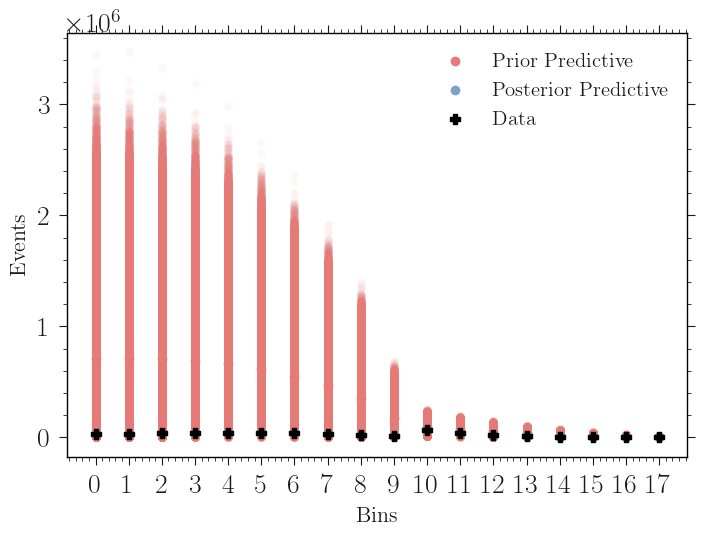

In [13]:
plotting.prior_posterior_predictives(model=model, data=yields, post_pred=post_pred, prior_pred=prior_pred)
plt.show()

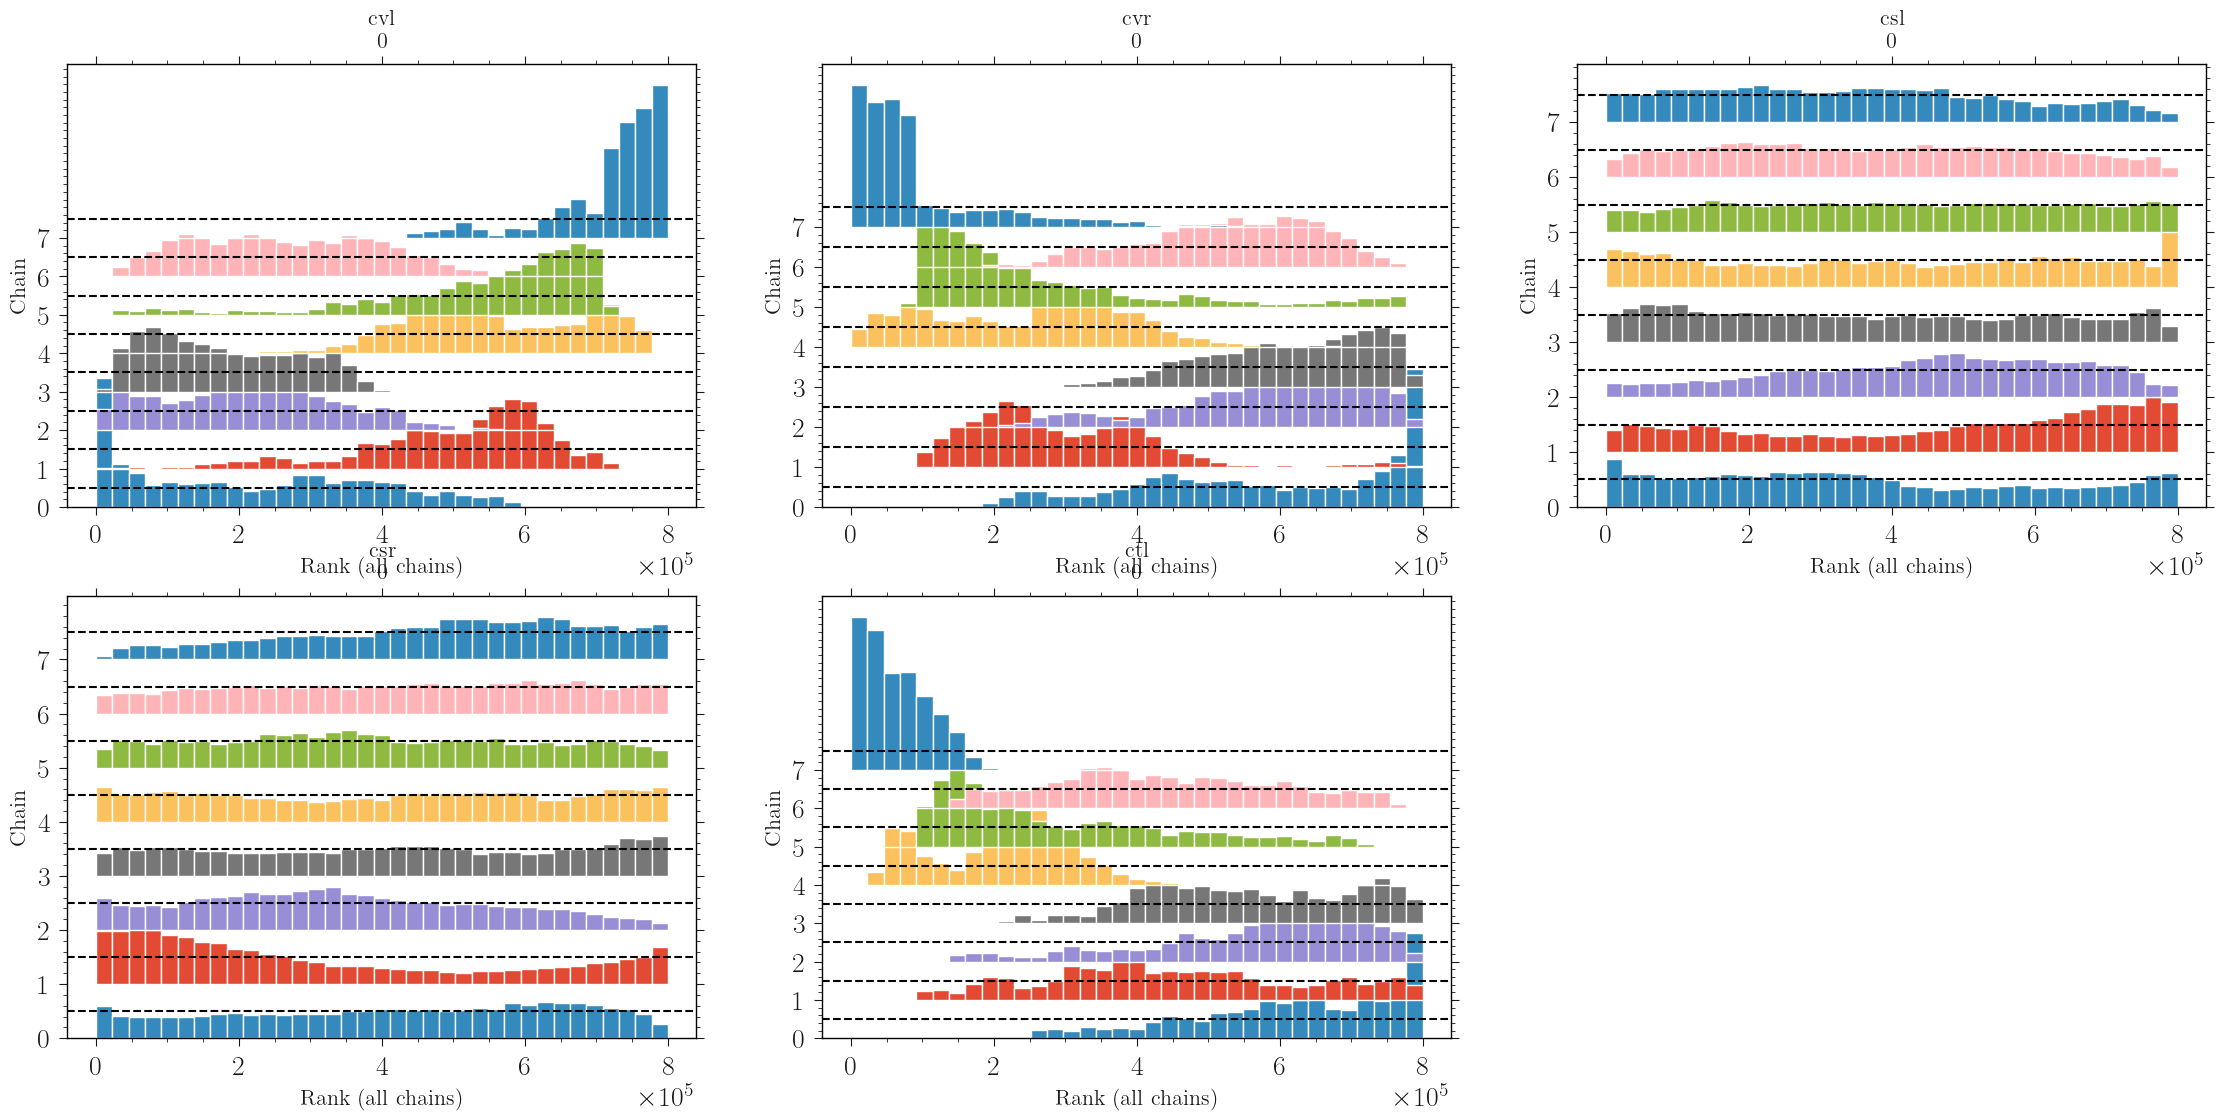

In [14]:
az.plot_rank(post_data, var_names=['cvl', 'cvr', 'csl', 'csr', 'ctl']);

array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'ess'}>, <Axes: title={'center': 'r_hat'}>],
      dtype=object)

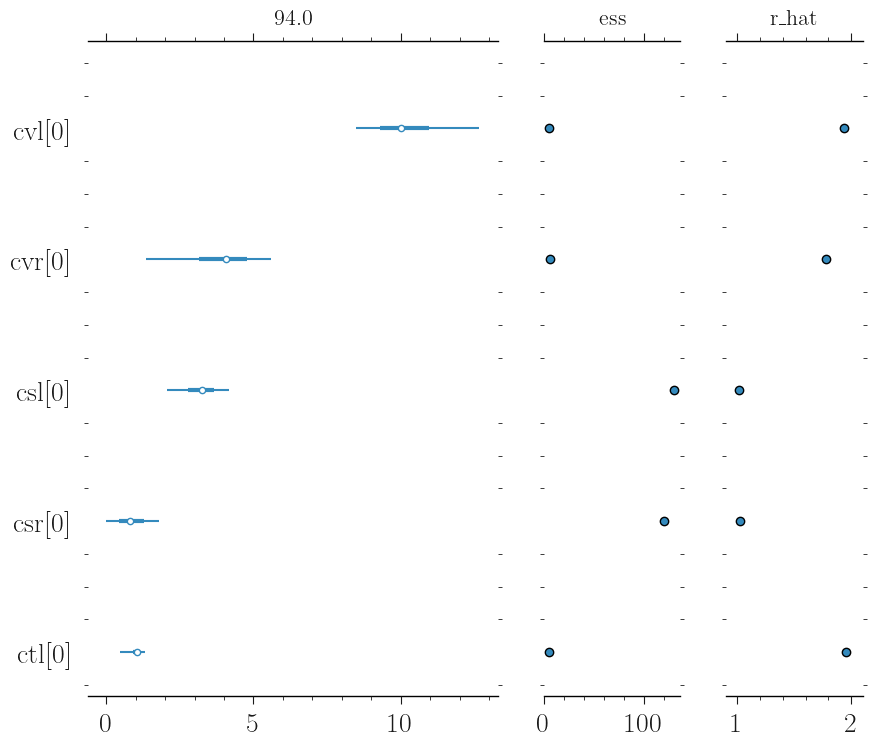

In [15]:
az.plot_forest(post_data, var_names=['cvl', 'cvr', 'csl', 'csr', 'ctl'], combined=True, ess=True, r_hat=True)

### apply symmetries

In [22]:
post_data_small = az.from_json( '../samples/comb_small_constr_post_data.json')

In [27]:
posteriors = []

for p in [post_data, post_data_small] :
    
    post_copy = p.copy()
    post_copy.posterior['cvl'].values = p.posterior['cvr'].values
    post_copy.posterior['cvr'].values = p.posterior['cvl'].values
    post_copy.posterior['csl'].values = p.posterior['csr'].values
    post_copy.posterior['csr'].values = p.posterior['csl'].values
    post_data_concat = az.concat(p, post_copy, dim='chain')

    post_copy = p.copy()
    post_copy.posterior['cvl'].values = p.posterior['cvr'].values
    post_copy.posterior['cvr'].values = p.posterior['cvl'].values
    post_data_concat = az.concat(post_data_concat, post_copy, dim='chain')

    post_copy = p.copy()
    post_copy.posterior['csl'].values = p.posterior['csr'].values
    post_copy.posterior['csr'].values = p.posterior['csl'].values
    post_data_concat = az.concat(post_data_concat, post_copy, dim='chain')
    
    posteriors.append(post_data_concat)


In [23]:

# post_data_copy = post_data_small.copy()
# post_data_copy.posterior['cvl'].values = post_data_smal.posterior['cvr'].values
# post_data_copy.posterior['cvr'].values = post_data_smal.posterior['cvl'].values
# post_data_copy.posterior['csl'].values = post_data_smal.posterior['csr'].values
# post_data_copy.posterior['csr'].values = post_data_smal.posterior['csl'].values
# post_data_small_concat = az.concat(post_data_small, post_data_copy, dim='chain')

# post_data_copy = post_data.copy()
# post_data_copy.posterior['cvl'].values = post_data.posterior['cvr'].values
# post_data_copy.posterior['cvr'].values = post_data.posterior['cvl'].values
# post_data_small_concat = az.concat(post_data_small_concat, post_data_copy, dim='chain')

# post_data_copy = post_data.copy()
# post_data_copy.posterior['csl'].values = post_data.posterior['csr'].values
# post_data_copy.posterior['csr'].values = post_data.posterior['csl'].values
# post_data_small_concat = az.concat(post_data_small_concat, post_data_copy, dim='chain')


In [8]:
# mirror option

# post_data_1 = post_data.copy()
# post_data_1.posterior['cvl'].values = 2*7-post_data.posterior['cvl'].values
# post_data_1.posterior['cvr'].values = 2*7-post_data.posterior['cvr'].values
# # post_data_1 = az.concat(post_data, post_data_copy, dim='chain')

# post_data_2 = post_data.copy()
# post_data_2.posterior['csl'].values = 2*2-post_data.posterior['csl'].values
# post_data_2.posterior['csr'].values = 2*2-post_data.posterior['csr'].values
# # post_data_2 = az.concat(post_data, post_data_copy, dim='chain')

# post_data_3 = post_data.copy()
# post_data_3.posterior['cvl'].values = 2*7-post_data.posterior['cvl'].values
# post_data_3.posterior['cvr'].values = 2*7-post_data.posterior['cvr'].values
# post_data_3.posterior['csl'].values = 2*2-post_data.posterior['csl'].values
# post_data_3.posterior['csr'].values = 2*2-post_data.posterior['csr'].values
# # post_data_3 = az.concat(post_data, post_data_copy, dim='chain')

# post_data_concat = az.concat(post_data, post_data_1, post_data_2, post_data_3, dim='chain')


### corner plot

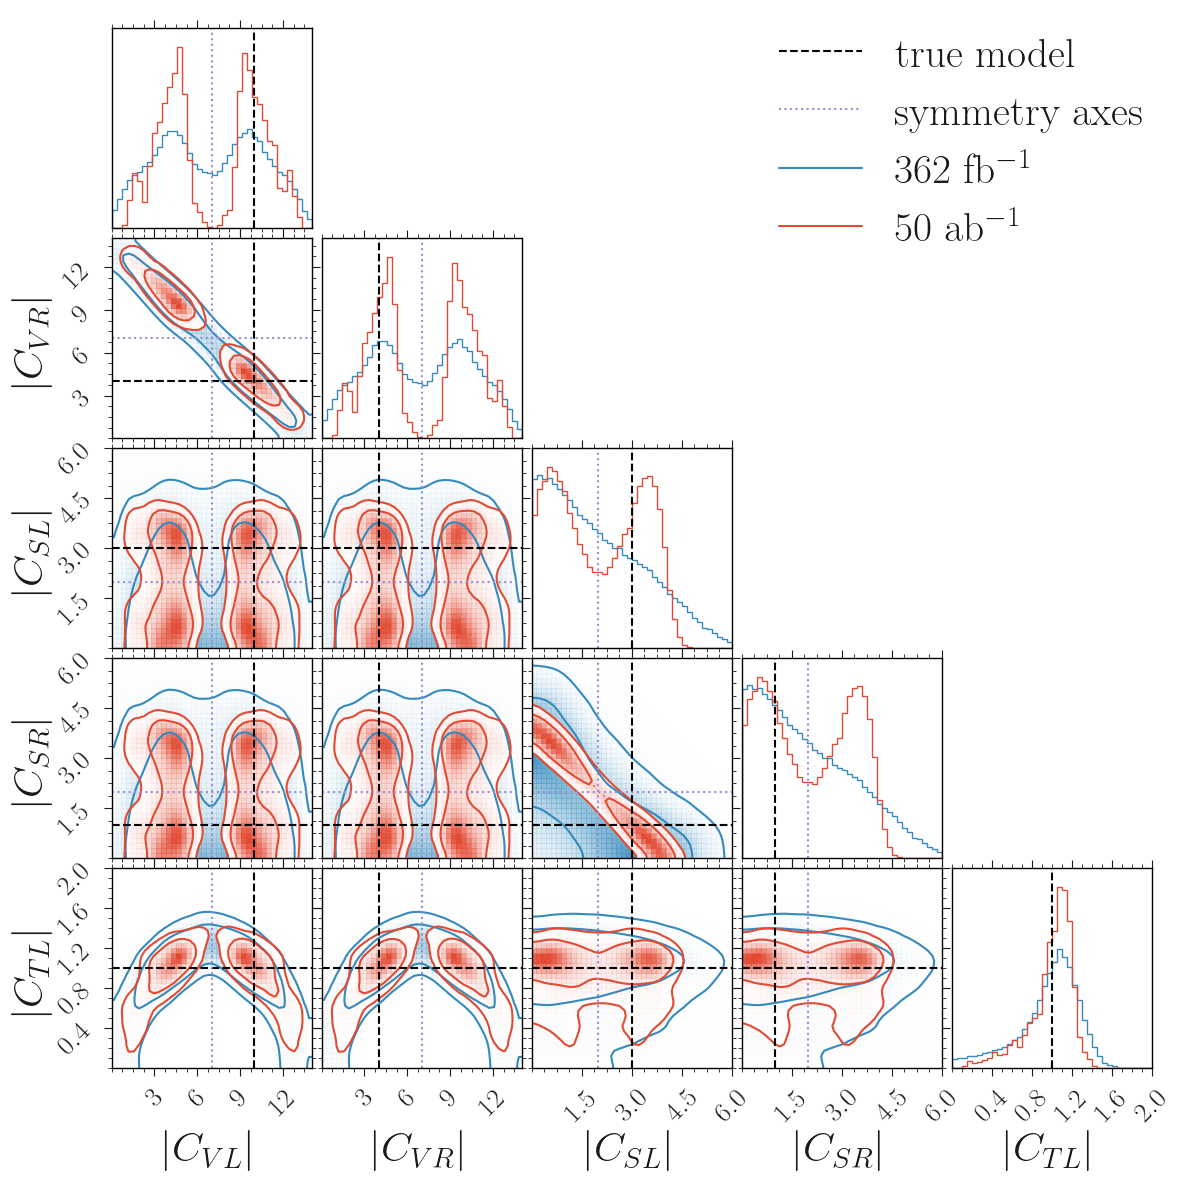

In [49]:
cvl = r'$|C_{VL}|$'
cvr = r'$|C_{VR}|$'
csl = r'$|C_{SL}|$'
csr = r'$|C_{SR}|$'
ctl = r'$|C_{TL}|$'
labels = [cvl, cvr, csl, csr, ctl]

plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})

file = '../results/combination_samples.pdf'

fig = corner.corner(posteriors[1].posterior, 
                    var_names=['cvl', 'cvr', 'csl', 'csr', 'ctl'],
                    bins=40, 
                    levels=(0.68, 0.95), 
                    # quantiles=(0.025, 0.975), 
                    range = [(0,14),(0,14),(0,6),(0,6),(0,2)],
                    smooth=1.3,
                    labels=labels,
                    color='C0',
                    plot_datapoints=False,
                    hist_kwargs={'density': True},
                    label_kwargs = {'fontsize':  30}
                    );

fig = corner.corner(posteriors[0].posterior, 
                    var_names=['cvl', 'cvr', 'csl', 'csr', 'ctl'],
                    bins=40, 
                    levels=(0.68, 0.95), 
                    # quantiles=(0.025, 0.975), 
                    range = [(0,14),(0,14),(0,6),(0,6),(0,2)],
                    smooth=1.3,
                    labels=labels,
                    color='C1',
                    plot_datapoints=False,
                    hist_kwargs={'density': True},
                    label_kwargs = {'fontsize':  30},
                    fig=fig
                    );

truewcs = [10, 4, 3, 1, 1]
corner.overplot_lines(fig, truewcs, color='k', label='true model', linestyle='--')

truewcs = [7, 7, 2, 2, None]
corner.overplot_lines(fig, truewcs, color='C2', label='symmetry axes', linestyle=':')

fig.legend(
        handles = fig.axes[0].get_legend_handles_labels()[0] + [
            mlines.Line2D([], [], color='C0', label=r'362 fb$^{-1}$'),
            mlines.Line2D([], [], color='C1', label=r'50 ab$^{-1}$')
            ],
        fontsize=30, loc="upper right"
    )

plt.savefig(file)
plt.show()